In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 7. Gradient free methods

### 7.1 Introduction

Gradient-free methods use only function values for minimization, therefore they are suitable for problems where gradients are not known, aren't useful or are too expensive to calculate. There is a huge number of various gradient-free methods and torchzero only implements a few (for now), but also provides wrappers for some other gradient-free optimization libraries with a lot of methods implemented.

### 7.2 Gradient approximations

When gradients are not available, one strategy is to estimate them using function values and use any of the gradient-based methods using the approximated gradients.

#### 7.2.1 Finite difference estimator

The **finite difference estimator** (FDM) loops over each parameter, adds a small perturbation to it and evaluates the function value, therefore it requires at least $n$ evaluations to estimate the gradient where $n$ is number of parameters. There are various finite difference formulas - 2-point forward/backward, 3-point central, 3-point forward/backward, 4 point central, etc.

The 3-point central is widely used. To estimate gradient of $i$-th parameter $x_i$, it evaluates function at $f(x_i - h)$ and $f(x_i + h)$, where $h$ is a hyperparameter controlling accuracy of the estimation. If precision was infinite, smaller $h$ means more accurate estimation, however due to finite precision $h$ can't be too small. Also if $h$ is large, it can have an effect of smoothing the function which is called **implicit filtering**, and can also be useful for functions with very rough surface. The formula for gradient of $i$-th parameter $g_i$ is the following:

$$
\hat{g_i} = \frac{f(x_i + h) - f(x_i - h)}{2 \cdot h}
$$

This formula has to be ran for each parameter, therefore $2n$ evaluations are required.

2-point forward formula is the following:
$$
\hat{g_i} = \frac{f(x_i + h) - f(x_i)}{h}
$$

This formula is less accurate, but by evaluating $f(x_i)$ once and reusing when estimating gradient of each parameter, it requires $n+1$ evaluations.

In torchzero to use FDM-approximated gradients, add `tz.m.FDM` as the first module.

finished in 0.2s., reached loss = 0.0413                                      
finished in 0.2s., reached loss = 4.35e-08                                      
finished in 0.1s., reached loss = 0                                      


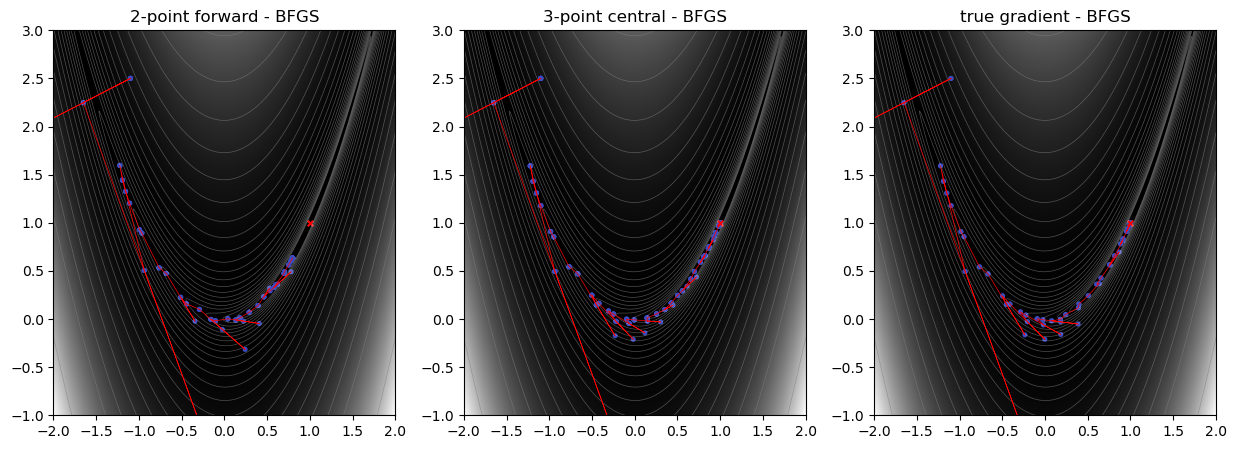

In [2]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = np.ravel(ax)

func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.FDM(formula='forward2'), tz.m.BFGS(), tz.m.Backtracking())
func.run(optimizer, max_steps=50)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("2-point forward - BFGS")

func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.FDM(formula='central3'), tz.m.BFGS(), tz.m.Backtracking())
func.run(optimizer, max_steps=50)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("3-point central - BFGS")

func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.BFGS(), tz.m.Backtracking())
func.run(optimizer, max_steps=50)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("true gradient - BFGS")

plt.show()

#### 7.2.2 Randomized finite difference estimator
Randomized finite difference estimator (RFDM) perturbs all parameters at once in a random direction.

$$
\hat{g} = p\frac{(f(x + h p) - f(x - h p))}{2 h}
$$

Here $h$ controls accuracy of the approximation, $p$ is a random perturbation with zero mean and variance of 1. This formula is direct equivalent of 3-point central formula, and other formulas can be used too.

This formula essentially estimates directional derivative in the direction $p$ and multiplies $p$ by it, which is a very rough estimate for full gradient.

Often $p$ is sample from the Rademacher distribution, so every value has 50% chance of being 1 and 50% of being -1, leading to the very popular **Simultaneous perturbation stochastic approximation** (SPSA) method. SPSA formula is often written with $p$ in the denominator (since multiplying and dividing by 1 and -1 is equivalent).

If $p$ isn' sampled from Rademacher distribution, we get **Random direction stochastic approximation** (RDSA) method.

 It is possible to calculate $\hat{g}$ multiple times with different random perturbations $p$, and then take the average. Then that average is an estimate of gradient in a subspace spanned by perturbations $p$, which is a slightly better estimate. The **gaussian smoothing** method averages multiple $p$ sampled from gaussian distribution, and $h$ can be made larger leading to the effect of smoothing the function.

RFDM doesn't suffer from having to perform $n$ evaluations per step just to approximate the gradient like in FDM. However the approximation is very rough and won't work with methods that rely on gradient differences, such as conjugate gradient and quasi-newton methods. It works with momentum and adaptive methods.

In torchzero to use RFDM-approximated gradients, add `tz.m.RandomizedFDM` as the first module. Or use one of `RandomizedFDM` subclasses - `tz.m.SPSA`, `tz.m.RDSA` and `tz.m.GaussianSmoothing`.

finished in 0.9s., reached loss = 0.112                                      
finished in 1.0s., reached loss = 0.00129                                      
finished in 2.7s., reached loss = 0.000152                                      


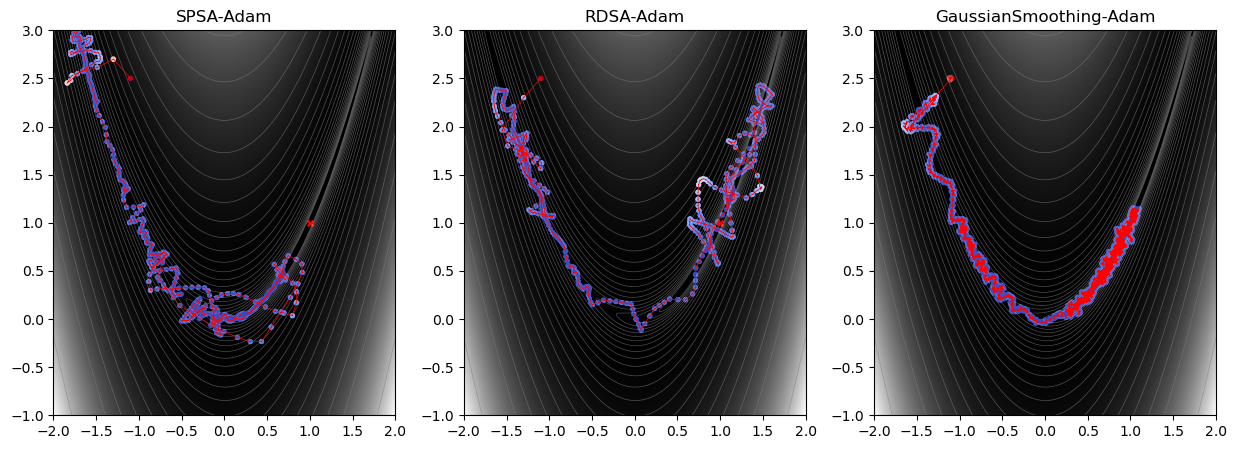

In [3]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = np.ravel(ax)

func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.SPSA(seed=0), tz.m.Adam(0.9, 0.95), tz.m.LR(2e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("SPSA-Adam")

func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.RDSA(seed=1), tz.m.Adam(0.9, 0.95), tz.m.LR(2e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("RDSA-Adam")

func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.GaussianSmoothing(n_samples=10, seed=0), tz.m.Adam(0.9, 0.95), tz.m.LR(2e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[2])
ax[2].set_title("GaussianSmoothing-Adam")

plt.show()

#### 7.2.3 MeZO
MeZO is a version of SPSA which uses the same formula, but the random perturbation $p$ is never stored in memory, instead only a seed used to generate it is stored and it is generated from the seed whenever needed. It has been proposed to fine-tune large language models when very limited memory is available. SPSA requires $2n$ extra memory, MeZO requires $n$ extra memory, where $n$ is number of parameters. Theoretically it could use almost no extra memory by generating and subtracting $p$ gradually weight by weight, not at once, but that isn't implemented in torchzero nor in [official implementation](https://github.com/princeton-nlp/MeZO/blob/main/large_models/trainer.py#L213).

Reference: [Malladi, Sadhika, et al. "Fine-tuning language models with just forward passes." Advances in Neural Information Processing Systems 36 (2023): 53038-53075.](https://arxiv.org/pdf/2305.17333)

finished in 3.4s., reached loss = 0.0593                                      


<Axes: >

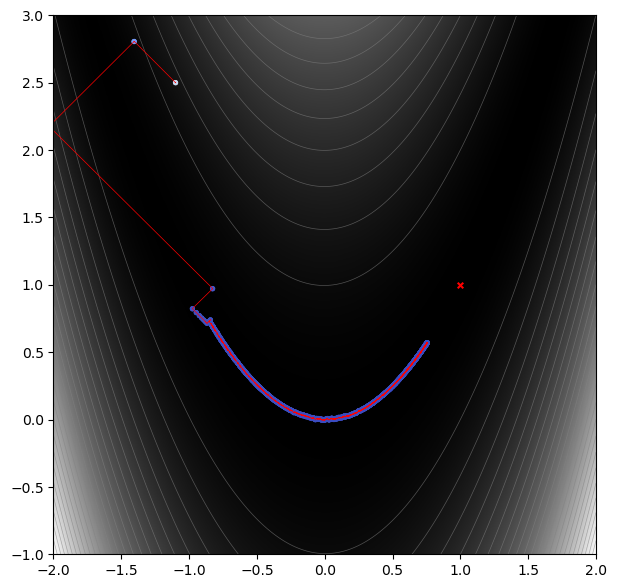

In [13]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.MeZO(),
    tz.m.LR(1e-3),
)
func.run(optimizer, max_steps=2000)
func.plot()

#### 7.2.4 Forward gradient
Instead of having to tune finite difference parameter $h$, exact directional derivative in the direction $p$ can be calculated using forward mode autograd via a jacobian-vector product (Jvp). Jvps can be cheap, in PyTorch they are experimental but still use way less memory than backward passes.

The formula is
$$
\hat{g} = p \cdot \nabla f(x)^T p
$$

This approximation has been called "Forward gradient".

Here $p$ is a random vector, $\nabla f(x)^T p$ is directional derivative in direction $p$ which can be calculated without calculating full gradient  $\nabla f(x)$.

Referenc: [Baydin, Atılım Güneş, et al. "Gradients without backpropagation." arXiv preprint arXiv:2202.08587 (2022).](https://arxiv.org/abs/2202.08587)

finished in 1.1s., reached loss = 0.0937                                      


<Axes: >

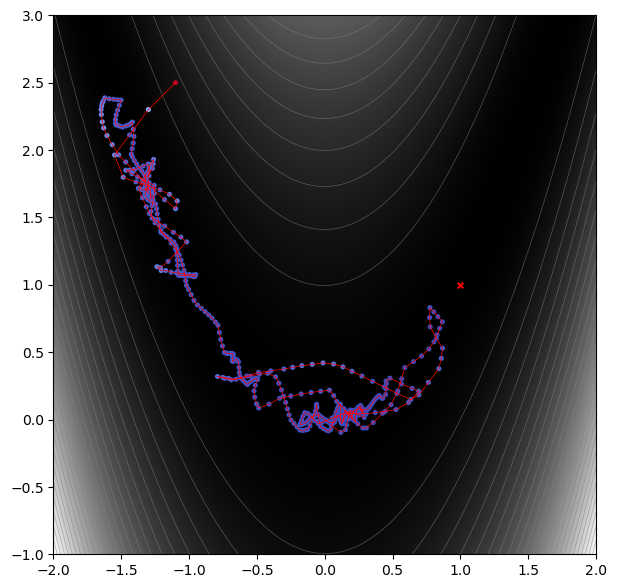

In [4]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.ForwardGradient(seed=1),
    tz.m.Adam(0.9, 0.95),
    tz.m.LR(2e-1),
)
func.run(optimizer, max_steps=500)
func.plot()

#### 7.2.5 Finite difference hessian-vector products

Certain second order optimizers such as NewtonCG and sketched Newton do not require the full hessian, they require just the hessian-vector products (Hvps) which can be computed efficiently via autograd. But in many case autograd fails because some rules aren't implemented, or maybe gradients are computed without autograd, then hessian-vector products can be estimated in one or two extra gradient computations using finite difference formulas. And, of course, we can use finite difference gradient approximations too, leading to a zeroth-order 
approximation to Newton's method.

The forward formula for estimating a hessian-vector product $Hv$ with vector $v$ is this:
$$
\widehat{Hv} = \frac{\nabla f(x + hv) - \nabla f(x)}{h}
$$

Here $h$ controls accuracy of the approximation. By pre-computing $\nabla f(x)$, it can be re-used for each subsequent hessian-vector product, leading to requiring one extra gradient computation per Hvp.

A more accurate central formula requires two extra gradient computations per Hvp:
$$
\widehat{Hv} = \frac{\nabla f(x + hv) - \nabla f(x - hv)}{2h}
$$

When using those formulas we can use finite difference approximation to $\nabla f(x)$.

In torchzero modules that use hessian-vector products have a `hvp_method` argument which can be set to `"forward"` to use forward formula or `"central"` to use central formula. By default it is usually set to `"autograd"` and uses automatic differentiation.

finished in 0.2s., reached loss = 3.99e-08                                      


<Axes: >

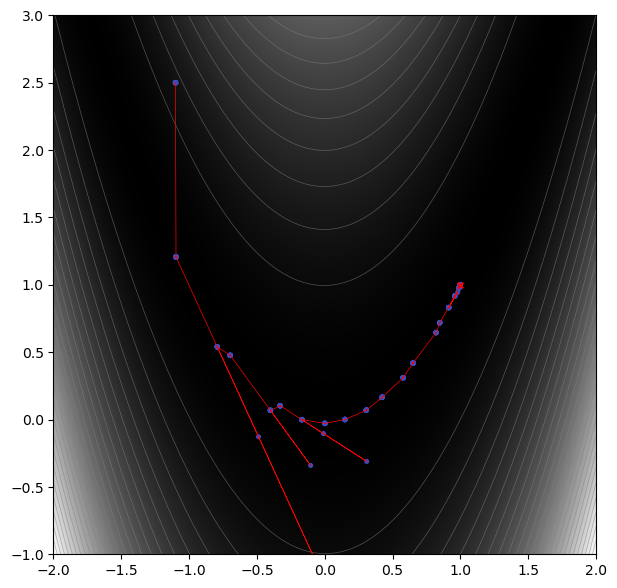

In [8]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(),
    tz.m.FDM(),
    tz.m.NewtonCG(hvp_method='central'),
    tz.m.Backtracking(),
)
func.run(optimizer, max_steps=20)
func.plot()